# Experiments with Similarity Encoders
In this iPython Notebook are some examples to illustrate the potential of Similarity Encoders (SimEc) for creating similarity preserving embeddings. For further details and theoretical background on this new neural network architecture, please see the corresponding paper (http://openreview.net/forum?id=SkBsEQYll).

The notebook is structured as follows: After a short toy example, we present several experiments performed on the sklearn handwritten digits dataset (a small real world dataset which works great to quickly test some things out). Then we present the results on the MNIST and 20 newsgroups datasets reported in the original paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
import theano.tensor as T
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.manifold import Isomap, TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import load_digits, fetch_mldata, fetch_20newsgroups

# find nlputils at https://github.com/cod3licious/nlputils
from nlputils.features import FeatureTransform, features2mat

from utils import load_dataset, plot2d, plot3d, plot_digits, plot_mnist, plot_20news
from similarity_encoder import SimilarityEncoder, center_K, scaled_sigmoid
from ann_models import SupervisedNNModel

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Toy Dataset: 3 Circles
Sanity check on an artifically generated toy dataset: Linear similarity encoders reach the same solution as PCA/linear kPCA (up to a rotation and scaling) and nicely map the test examples where they belong.

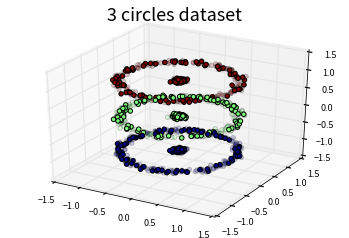

In [2]:
n_train = 1000
n_test = 500
dataset = '3_circles'
# get training and test data
X, Y_plot = load_dataset(dataset, n_train, 3)
X_test, Y_plot_test = load_dataset(dataset, n_test, 5)
# plot the original data
plot3d(X, Y_plot, X_test, Y_plot_test, title='%s dataset' % dataset.replace('_', ' '))

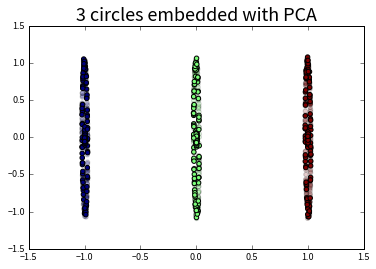

In [3]:
# simple 2D PCA solution
e_pca = PCA(n_components=2)
X_embed = e_pca.fit_transform(X)
X_embed_test = e_pca.transform(X_test)
plot2d(X_embed, Y_plot, X_embed_test, Y_plot_test, title='%s embedded with PCA' % dataset.replace('_', ' '))

Final training error: 0.0124266271; lowest error: 0.0124266271
Last mean error: 0.0124263179


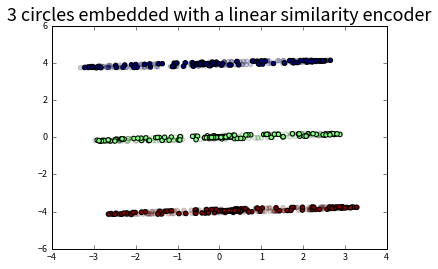

In [4]:
# similarity encoder no activation function, linear similarities as targets
K_lin = np.dot(X, X.T)
e_lsimenc = SimilarityEncoder(K_lin.shape[1], X.shape[1], e_dim=2, orthOT_reg=0.1)
e_lsimenc.fit(X, K_lin, verbose=False)
X_embed = e_lsimenc.transform(X)
X_embed_test = e_lsimenc.transform(X_test)
plot2d(X_embed, Y_plot, X_embed_test, Y_plot_test, title='%s embedded with a linear similarity encoder' % dataset.replace('_', ' '))

## Handwritten Digits (8x8 px)
See `http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html`

In [5]:
# load digits dataset
digits = load_digits()
X = digits.data
X /= float(X.max())
y = digits.target
n_samples, n_features = X.shape

#### Linear kernel PCA
A linear SimEc gets the same solution as PCA (= linear kernel PCA) up to a rotation

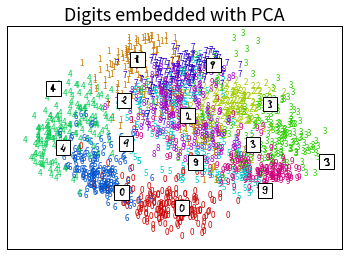

In [6]:
# PCA
e_pca = PCA(n_components=2)
X_embed = e_pca.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with PCA')

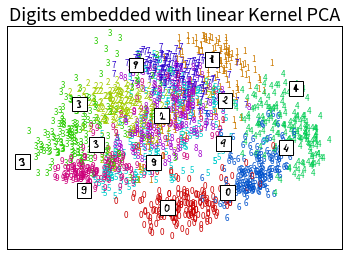

In [7]:
# linear kPCA - same as regular PCA...;)
e_lkpca = KernelPCA(n_components=2, kernel='linear')
X_embed = e_lkpca.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with linear Kernel PCA')

Final training error: 0.0097277279; lowest error: 0.0097277279
Last mean error: 0.0097273537


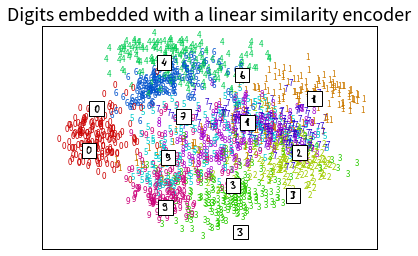

In [8]:
# linear similarity encoder (center the kernel matrix first!)
K_lin = np.dot(X, X.T)
e_lsimenc = SimilarityEncoder(K_lin.shape[1], X.shape[1], e_dim=2, orthOT_reg=0.1)
e_lsimenc.fit(X, center_K(K_lin), verbose=False)
X_embed = e_lsimenc.transform(X)
plot_digits(X_embed, digits, title='Digits embedded with a linear similarity encoder')

#### Non-linear spectral methods
Linear kPCA is straight forward, but what if we use a non-linear kernel function like the Gaussian kernel or isomap?
For the corresponding SimEcs we add two non-linear hidden layers.

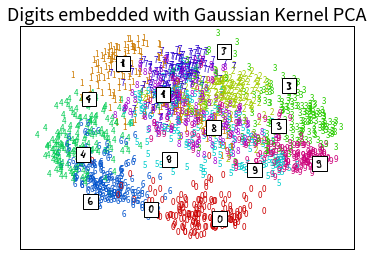

In [9]:
# Gaussian kernel PCA
D = squareform(pdist(X, 'euclidean'))
gamma = 1./(np.median(D)**2)    
e_gkpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
X_embed = e_gkpca.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with Gaussian Kernel PCA')

Final training error: 0.0080230404; lowest error: 0.0080230404
Last mean error: 0.0080228304


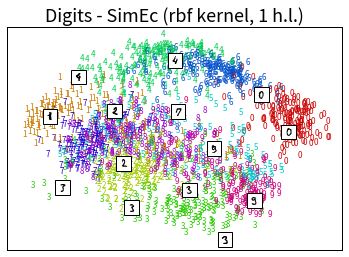

In [13]:
# non-linear SimEc with rbf kernel
K_rbf = rbf_kernel(X, X, gamma)
e_gsimenc = SimilarityEncoder(K_rbf.shape[1], X.shape[1], 2, [40], [T.nnet.relu, None, None], lrate=2., orthOT_reg=0.1)
e_gsimenc.fit(X, center_K(K_rbf), verbose=False)
X_embed = e_gsimenc.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (rbf kernel, 1 h.l.)')

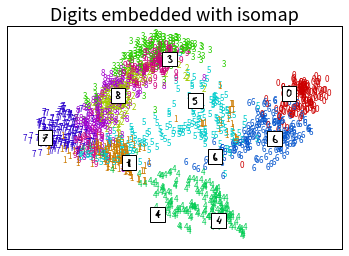

In [11]:
# isomap
e_isomap = Isomap(n_neighbors=10, n_components=2)
X_embed = e_isomap.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with isomap')

Final training error: 0.0131738839; lowest error: 0.0131738839
Last mean error: 0.0131737021


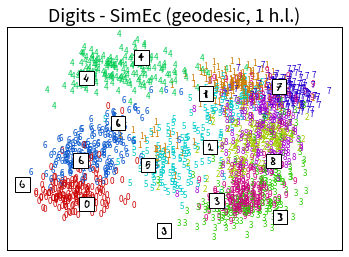

In [14]:
# non-linear SimEc based on isomap
K_geod = e_isomap.dist_matrix_
e_gsimenc = SimilarityEncoder(K_geod.shape[1], X.shape[1], 2, [40], [T.nnet.relu, None, None], lrate=2., orthOT_reg=0.01)
e_gsimenc.fit(X, center_K(K_geod), verbose=False)
X_embed = e_gsimenc.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (geodesic, 1 h.l.)')

#### t-SNE
A visualization like that created with t-SNE might look better. (But do you notice those few examples trapped between the clusters? This happens because the embedding coordinates are optimized directly instead of learning a mapping function.) - we're not there yet with SimEcs, this calls for different cost functions etc.

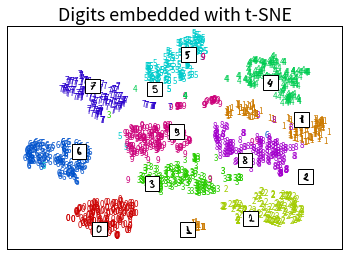

In [15]:
# t-SNE
e_tsne = TSNE(n_components=2, random_state=1, method='exact')
X_embed = e_tsne.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with t-SNE')

#### SimEc based on class labels
We've seen that SimEcs can reach the same solutions as traditional spectral methods such as kPCA and isomap. However, these methods have the limitation that you can only embed new data points if you can compute their kernel map, i.e. the similarity to the training examples. But what if the similarity matrix used as targets during training was generated by an unknown process such as human similarity judgements? KPCA will probably fail completely since it requires a positive semi-definite kernel function... But we can still use SimEcs!

To show this, we construct the similarity matrix from the class labels assigned by human annotators (1=same class, 0=different class).

In [16]:
Y = np.tile(y, (len(y), 1))
S = np.array(Y==Y.T, dtype=int)

Lets first try a simple linear SimEc.

Final training error: 0.0738721318; lowest error: 0.0738509187
Last mean error: 0.0738236345


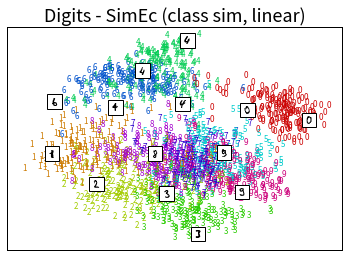

In [17]:
# similarity encoder with similarities relying on class information - linear
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [], [None, None], lrate=5., orthOT_reg=0.1)
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (class sim, linear)')

Well, this is very similar to the original linear SimEc that did not make use of class labels, so this is kind of disappointing. Here we didn't center the similarty matrix - might that help?

Final training error: 0.0897205866; lowest error: 0.0896948106
Last mean error: 0.0897165631


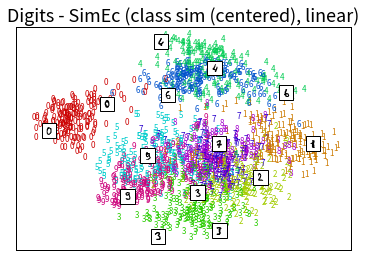

In [18]:
# similarity encoder with similarities relying on class information - linear; center S
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [], [None, None], lrate=5., orthOT_reg=0.1)
e_csimenc.fit(X, center_K(S), verbose=False)
X_embed = e_csimenc.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (class sim (centered), linear)')

Ok, this looks exactly the same. But we know the target similarities are either 0 or 1, so we could make use of this information an apply a thresholding function to our output to optimize the results. More concrete: we don't center S but map the output almost linearly between 0 and 1 while fixing it to 0 or 1 outside this interval.

Final training error: 0.0573541938; lowest error: 0.0573451486
Last mean error: 0.0573443776


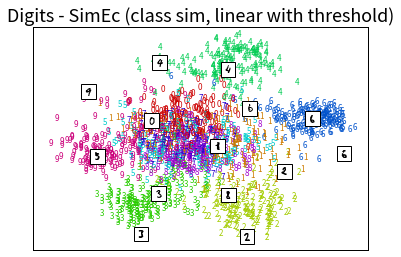

In [19]:
# similarity encoder with similarities relying on class information - linear
# no centering of S but instead a thresholding in the last layer to transform the output to be between 0 and 1
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [], [None, scaled_sigmoid], lrate=5., orthOT_reg=0.1)
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (class sim, linear with threshold)')

Great, we already see some clusters separating from the rest! However, with this additional non-linearity in the last layer, it is not really efficient to optimize the mean squared error due to the vanishing gradients problem; instead we will optimize the cross-entropy.

Final training error: 0.1928502087; lowest error: 0.1928502087
Last mean error: 0.1928121970


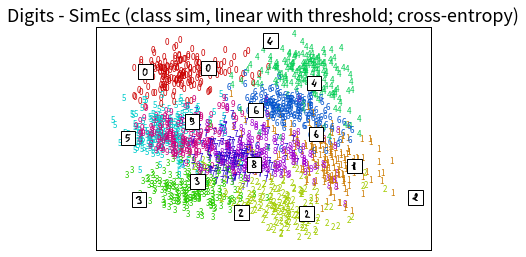

In [20]:
# similarity encoder with similarities relying on class information - linear
# thresholding on the output, optimize cross-entropy
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [], [None, scaled_sigmoid], lrate=0.5, orthOT_reg=0.1, error_fun='cross-entropy')
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (class sim, linear with threshold; cross-entropy)')

Of course, the main question now is: how much better do we get if we add more layers?!!

Final training error: 0.1110276611; lowest error: 0.1110276611
Last mean error: 0.1109586768


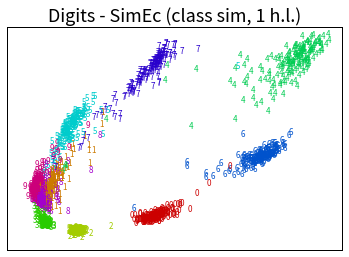

In [21]:
# similarity encoder with similarities relying on class information - 1 hidden layer
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [100], [T.tanh, None, scaled_sigmoid], lrate=0.5, orthOT_reg=0.05, error_fun='cross-entropy')
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (class sim, 1 h.l.)', plot_box=False)

Final training error: 0.0620598045; lowest error: 0.0620598045
Last mean error: 0.0620060391


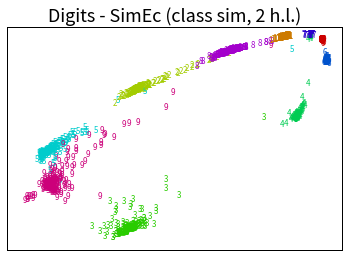

In [22]:
# similarity encoder with similarities relying on class information - 2 hidden layers
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [100, 50], [T.tanh, T.tanh, None, scaled_sigmoid], lrate=0.5, orthOT_reg=0.005, error_fun='cross-entropy')
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (class sim, 2 h.l.)', plot_box=False)

With a target similarity matrix based on class membership the SimEc nicely clusters data points belonging to the same class. Just for comparison, let's see how this looks like if we use a network optimized for the corresponding classification task, but where we use only two neurons in the second to last layer and visualize the embeddings of this.

Final training error: 0.066307


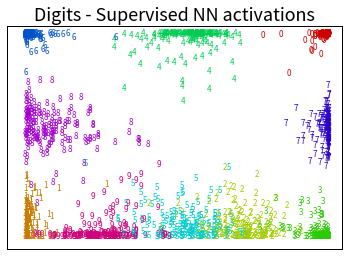

In [24]:
model = SupervisedNNModel(X.shape[1], 10, hunits=[100, 2], activations=[T.tanh, T.tanh, T.nnet.softmax], cost_fun='negative_log_likelihood',
                          error_fun='zero_one_loss', learning_rate=0.01, L1_reg=0., L2_reg=0.0001)
model.fit(X, y, verbose=False)
# plot embedding
X_embed = model.transform(X)
plot_digits(X_embed, digits, title='Digits - Supervised NN activations', plot_box=False)

## MNIST Dataset
Embedding the regular 28x28 pixel MNIST digits

In [25]:
# load digits
mnist = fetch_mldata('MNIST original', data_home='data')
X = mnist.data/255.  # normalize to 0-1
y = np.array(mnist.target, dtype=int)
# subsample 10000 random data points
np.random.seed(42)
n_samples = 10000
n_test = 2000
rnd_idx = np.random.permutation(X.shape[0])[:n_samples]
X_test, y_test = X[rnd_idx[:n_test],:], y[rnd_idx[:n_test]]
X, y = X[rnd_idx[n_test:],:], y[rnd_idx[n_test:]]
n_train, n_features = X.shape

#### Linear SimEc
Linear SimEc again gives the same solution as PCA/linear kPCA.

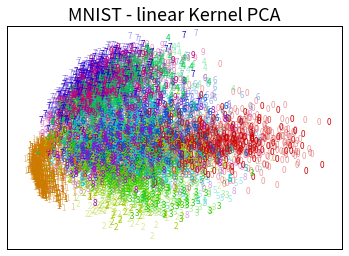

In [26]:
# linear kPCA
e_lkpca = KernelPCA(n_components=2, kernel='linear')
X_embed = e_lkpca.fit_transform(X)
X_embed_test = e_lkpca.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - linear Kernel PCA')

Final training error: 0.0034702930; lowest error: 0.0034702930
Last mean error: 0.0034702195


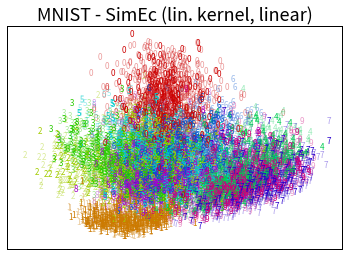

In [27]:
# linear similarity encoder (center the kernel matrix first!)
K_lin = np.dot(X, X.T)
e_lsimenc = SimilarityEncoder(K_lin.shape[1], X.shape[1], e_dim=2, lrate=1., orthOT_reg=0.1)
e_lsimenc.fit(X, center_K(K_lin), verbose=False)
X_embed = e_lsimenc.transform(X)
X_embed_test = e_lsimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (lin. kernel, linear)')

#### Non-linear SimEc
Isomap and corresponding SimEc with 2 hidden layers.

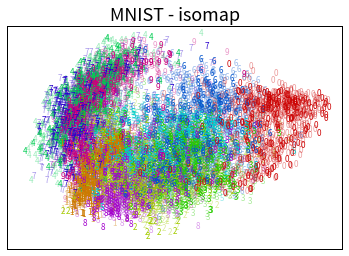

In [28]:
# isomap
e_isomap = Isomap(n_neighbors=10, n_components=2)
X_embed = e_isomap.fit_transform(X)
X_embed_test = e_isomap.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - isomap')

Final training error: 0.0079275022; lowest error: 0.0079275022
Last mean error: 0.0079273632


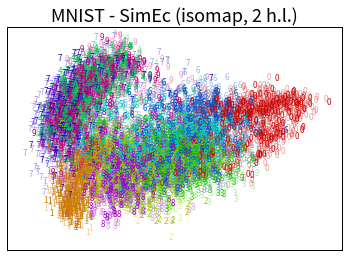

In [29]:
# non-linear SimEc to approximate isomap solution
K_geod = e_isomap.dist_matrix_
e_gsimenc = SimilarityEncoder(K_geod.shape[1], X.shape[1], 2, [100, 20], [T.nnet.relu, T.nnet.relu, None, None], lrate=2., orthOT_reg=0.02)
e_gsimenc.fit(X, center_K(K_geod), verbose=False)
X_embed = e_gsimenc.transform(X)
X_embed_test = e_gsimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (isomap, 2 h.l.)')

#### Supervised SimEc
Try SimEcs with a varying number of non-linear hidden layers to approximate class-based similarities in the embedding.

Final training error: 0.2011573479; lowest error: 0.2011573479
Last mean error: 0.2011229545


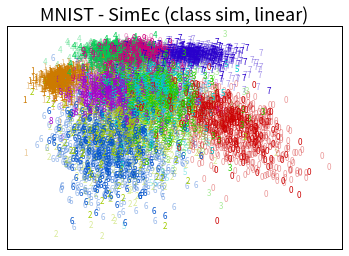

In [32]:
# similarity encoder with similarities relying on class information - linear
Y = np.tile(y, (len(y), 1))
S = np.array(Y==Y.T, dtype=int)
# we again use thresholding on the output and the cross-entropy cost function
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [], [None, scaled_sigmoid],
                              orthOT_reg=0., lrate=.00001, lrate_decay=1., error_fun='cross-entropy')
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
X_embed_test = e_csimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (class sim, linear)')

Final training error: 0.0922127717; lowest error: 0.0922127717
Last mean error: 0.0921338742


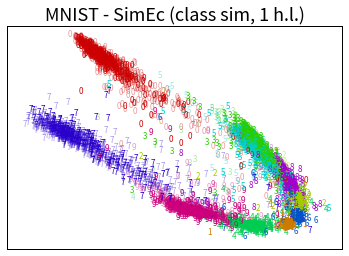

In [ ]:
# class labels - 1 hidden layer
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [100], [
                              T.tanh, None, scaled_sigmoid], orthOT_reg=0., lrate=.00001, lrate_decay=1., error_fun='cross-entropy')
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
X_embed_test = e_csimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (class sim, 1 h.l.)')

In [ ]:
# class labels - 2 hidden layers
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [100, 50], [
                              T.tanh, T.tanh, None, scaled_sigmoid], orthOT_reg=0., lrate=.00001, lrate_decay=1., error_fun='cross-entropy')
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
X_embed_test = e_csimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (class sim, 2 h.l.)')

In [ ]:
# class labels - 3 hidden layers
e_csimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [100, 50, 30], [
                              T.tanh, T.tanh, T.tanh, None, scaled_sigmoid], orthOT_reg=0., lrate=0.01, lrate_decay=0.99, error_fun='cross-entropy')
e_csimenc.fit(X, S, verbose=False)
X_embed = e_csimenc.transform(X)
X_embed_test = e_csimenc.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - SimEc (class sim, 3 h.l.)')

## 20 Newsgroups
To show that SimEc embeddings can also be computed for other types of data, we do some further experiments with the 20 newsgroups dataset. We subsample 7 of the 20 categories and remove meta information such as headers to avoid overfitting (see also `http://scikit-learn.org/stable/datasets/twenty_newsgroups.html`). The posts are transformed into very high dimensional tf-idf vectors used as input to the SimEc and to compute the linear kernel matrix.

In [ ]:
## load the data and transform it into a tf-idf representation
categories = [
    "comp.graphics",
    "rec.autos",
    "rec.sport.baseball",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns"
]
newsgroups_train = fetch_20newsgroups(subset='train', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
# store in dicts
textdict = {i: t for i, t in enumerate(newsgroups_train.data)}
textdict.update({i: t for i, t in enumerate(newsgroups_test.data, len(newsgroups_train.data))})
train_ids = range(len(newsgroups_train.data))
test_ids = range(len(newsgroups_train.data), len(textdict))
print "%i training and %i test samples" % (len(train_ids), len(test_ids))
# transform into tf-idf features
ft = FeatureTransform(norm='max', weight=True, renorm='max')
docfeats = ft.texts2features(textdict, fit_ids=train_ids)
# organize in feature matrix
X, featurenames = features2mat(docfeats, train_ids)
X_test, _ = features2mat(docfeats, test_ids, featurenames)
print "%i features" % len(featurenames)
y, y_test, target_names = newsgroups_train.target, newsgroups_test.target, newsgroups_train.target_names

#### Linear SimEc
Again, linear kPCA and SimEc give the same solution (up to a rotation). Btw, here we can't use regular PCA as the covariance matrix would be very high dimensional and poorly estimated due to the small amout of samples.

In [ ]:
# linear kPCA
e_lkpca = KernelPCA(n_components=2, kernel='linear')
X_embed = e_lkpca.fit_transform(X)
X_embed_test = e_lkpca.transform(X_test)
plot_20news(X_embed, y, target_names, X_embed_test, y_test, title='20newsgroups - linear Kernel PCA', legend=True)

In [ ]:
# compute linear kernel and center
K = X.dot(X.T).A
K_cent = center_K(K)
# project to 2d with linear similarity encoder
e_lsimenc = SimilarityEncoder(K_cent.shape[1], X.shape[1], 2, [], [None, None], sparse_features=True, lrate=100., lrate_decay=0.95, orthOT_reg=0.00025)
e_lsimenc.fit(X, K_cent, verbose=False)
X_embed = e_lsimenc.transform(X)
X_embed_test = e_lsimenc.transform(X_test)
plot_20news(X_embed, y, target_names, X_embed_test, y_test,
            title='20 newsgroups - SimEc (lin. kernel, linear)')

#### Supervised SimEc
Non-linear SimEc to create a 2d embedding in which the class-based similarities are retained. (Btw, the scaled sigmoid also works well as an activation function for earlier hidden layers.)

In [ ]:
# compute label based simmat
Y = np.tile(y, (len(y), 1))
S = np.array(Y==Y.T, dtype=int)
# project to 2d with similarity encoder
e_lsimenc = SimilarityEncoder(S.shape[1], X.shape[1], 2, [100], [scaled_sigmoid, None, scaled_sigmoid], sparse_features=True, orthOT_reg=0., lrate=1., lrate_decay=1., error_fun='cross-entropy')
e_lsimenc.fit(X, S, verbose=False)
X_embed = e_lsimenc.transform(X)
X_embed_test = e_lsimenc.transform(X_test)
plot_20news(X_embed, y, target_names, X_embed_test, y_test,
            title='20 newsgroups - SimEc (class sim, 1 h.l.)')